# Adverse Events to Regulations Matching

Goal: To match FDA adverse events to relevant regulations to help users identify which regulations apply to fix issues.

### Use Cases (including but not limitted to):
- Identify which regulations were violated based on adverse events
- Find relevant regulations to address specific issues
- Understand regulatory requirements for reported problems


## Import Libraries


In [ ]:
# Install required packages
import subprocess
import sys

packages = [
    "pandas",
    "numpy",
    "matplotlib",
    "seaborn",
    "sentence-transformers",
    "faiss-cpu",
    "scikit-learn",
    "tqdm",
    "pyarrow"
]

for package in packages:
    try:
        if package == "sentence-transformers":
            __import__("sentence_transformers")
        elif package == "faiss-cpu":
            __import__("faiss")
        else:
            __import__(package.replace("-", "_"))
        print(f"✓ {package} already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])

print("\n✓ All packages installed")

✓ pandas already installed
✓ numpy already installed
✓ matplotlib already installed
✓ seaborn already installed
✓ sentence-transformers already installed
✓ faiss-cpu already installed
Installing scikit-learn...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


✓ tqdm already installed
✓ pyarrow already installed

✓ All packages installed


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import json
from typing import List, Dict, Tuple, Optional
import re
from collections import Counter
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# For embeddings and matching
from sentence_transformers import SentenceTransformer
import faiss

# For progress bars
from tqdm.auto import tqdm

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 200)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported")

✓ Libraries imported


## Setup Paths and Configuration


In [ ]:
# Setup paths
BASE_DIR = Path("/Users/Kay Michnicki/AllCode/FDA Data Scraping")

# Data directories
AE_DATA_DIR = BASE_DIR / "fda_adverse_events_recalls" / "adverse_events"
REGULATIONS_DATA_DIR = BASE_DIR / "fda_output_cleaned"
OUTPUT_DIR = BASE_DIR / "adverse_events_regulations_matching"
OUTPUT_DIR.mkdir(exist_ok=True)

# Matching configuration
EMBEDDING_MODEL = "sentence-transformers/all-mpnet-base-v2"
TOP_K_REGULATIONS = 5  # Number of top regulations to match per adverse event
MIN_SIMILARITY_SCORE = 0.4  # Minimum similarity score threshold
USE_COSINE_SIMILARITY = True  # Use cosine similarity

print("ADVERSE EVENTS TO REGULATIONS MATCHER")
print(f"\nBase directory: {BASE_DIR}")
print(f"Adverse events data: {AE_DATA_DIR}")
print(f"Regulations data: {REGULATIONS_DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"\nMatching configuration:")
print(f"  Embedding model: {EMBEDDING_MODEL}")
print(f"  Top K regulations: {TOP_K_REGULATIONS}")
print(f"  Min similarity score: {MIN_SIMILARITY_SCORE}")
print(f"  Use cosine similarity: {USE_COSINE_SIMILARITY}")

ADVERSE EVENTS TO REGULATIONS MATCHER

Base directory: /Users/Kay Michnicki/AllCode/FDA Data Scraping
Adverse events data: /Users/Kay Michnicki/AllCode/FDA Data Scraping/fda_adverse_events_recalls/adverse_events
Regulations data: /Users/Kay Michnicki/AllCode/FDA Data Scraping/fda_output_cleaned
Output directory: /Users/Kay Michnicki/AllCode/FDA Data Scraping/adverse_events_regulations_matching

Matching configuration:
  Embedding model: all-MiniLM-L6-v2
  Top K regulations: 5
  Min similarity score: 0.3


## Load Adverse Events Data


In [ ]:
# Load adverse events data - ONLY from category-specific files for strict category matching
print("Loading category-specific adverse events")

category_files = {
    'Drugs': AE_DATA_DIR / "drug_adverse_events.parquet",
    'Biologics': AE_DATA_DIR / "biologics_adverse_events.parquet",
    'MedicalDevices': AE_DATA_DIR / "device_adverse_events.parquet"
}

dfs = []
for category, file_path in category_files.items():
    if file_path.exists():
        df = pd.read_parquet(file_path)
        df['product_category'] = category
        dfs.append(df)
        print(f"✓ Loaded {len(df):,} {category} adverse events")
    else:
        print(f"⚠ {category} file not found: {file_path}")

if not dfs:
    raise FileNotFoundError(f"No category-specific adverse event files found in {AE_DATA_DIR}")

df_ae = pd.concat(dfs, ignore_index=True)
print(f"\n✓ Total loaded: {len(df_ae):,} adverse events")
print(f"\nCategory distribution:")
print(df_ae['product_category'].value_counts())

print(f"\nDataset shape: {df_ae.shape}")
print(f"Columns: {list(df_ae.columns)}")
print(f"\nFirst few rows:")
df_ae.head()

Loading adverse events data...
✓ Loaded 1,000 adverse events

Dataset shape: (1000, 17)
Columns: ['safetyreportid', 'receivedate', 'serious', 'seriousnessdeath', 'seriousnesslifethreatening', 'seriousnesshospitalization', 'seriousnessdisabling', 'drug_product_name', 'drug_generic_name', 'drug_brand_name', 'adverse_reactions', 'reaction_count', 'patient_age', 'patient_age_unit', 'patient_sex', 'outcome', 'raw_data']

First few rows:


,safetyreportid,receivedate,serious,seriousnessdeath,seriousnesslifethreatening,seriousnesshospitalization,seriousnessdisabling,drug_product_name,drug_generic_name,drug_brand_name,adverse_reactions,reaction_count,patient_age,patient_age_unit,patient_sex,outcome,raw_data
0,5801206-7,20080707,1,1,,,,DURAGESIC-100,,,"DRUG ADMINISTRATION ERROR, OVERDOSE",2,26,801,1,,"{""safetyreportid"": ""5801206-7"", ""transmissiondateformat"": ""102"", ""transmissiondate"": ""20090109"", ""serious"": ""1"", ""seriousnessdeath"": ""1"", ""receivedateformat"": ""102"", ""receivedate"": ""20080707"", ""re..."
1,10003300,20140306,1,,,,1,BONIVA,,,"Vomiting, Diarrhoea, Arthralgia, Headache",4,77,801,2,,"{""safetyreportversion"": ""1"", ""safetyreportid"": ""10003300"", ""primarysourcecountry"": ""US"", ""transmissiondateformat"": ""102"", ""transmissiondate"": ""20141002"", ""reporttype"": ""1"", ""serious"": ""1"", ""seriou..."
2,10003301,20140228,1,,,,,IBUPROFEN,,IBUPROFEN,"Dyspepsia, Renal impairment",2,,,2,,"{""safetyreportversion"": ""1"", ""safetyreportid"": ""10003301"", ""primarysourcecountry"": ""US"", ""transmissiondateformat"": ""102"", ""transmissiondate"": ""20141002"", ""reporttype"": ""1"", ""serious"": ""1"", ""seriou..."
3,10003302,20140312,2,,,,,LYRICA,,LYRICA,Drug ineffective,1,,,1,6,"{""safetyreportversion"": ""1"", ""safetyreportid"": ""10003302"", ""primarysourcecountry"": ""US"", ""occurcountry"": ""US"", ""transmissiondateformat"": ""102"", ""transmissiondate"": ""20141002"", ""reporttype"": ""1"", ""..."
4,10003304,20140312,2,,,,,DOXYCYCLINE HYCLATE,,DOXYCYCLINE HYCLATE,Drug hypersensitivity,1,,,2,6,"{""safetyreportversion"": ""2"", ""safetyreportid"": ""10003304"", ""primarysourcecountry"": ""US"", ""occurcountry"": ""US"", ""transmissiondateformat"": ""102"", ""transmissiondate"": ""20141212"", ""reporttype"": ""1"", ""..."


In [ ]:
# Clean and prepare adverse events data
print("Cleaning adverse events data")

# Create a combined text field for matching
def create_ae_text(row):
    """Create a comprehensive text description from adverse event data with enhanced context"""
    parts = []
    
    # Product information (more detailed)
    if pd.notna(row.get('drug_product_name')):
        parts.append(f"Product name: {row['drug_product_name']}")
    if pd.notna(row.get('drug_generic_name')):
        parts.append(f"Generic name: {row['drug_generic_name']}")
    if pd.notna(row.get('drug_brand_name')):
        parts.append(f"Brand name: {row['drug_brand_name']}")
    
    # Adverse reactions (expand with context)
    if pd.notna(row.get('adverse_reactions')):
        reactions = str(row['adverse_reactions'])
        parts.append(f"Reported adverse reactions include: {reactions}")
        parts.append(f"Adverse events reported: {reactions}")
    
    # Seriousness information (more descriptive)
    seriousness = []
    if pd.notna(row.get('serious')) and str(row['serious']) == '1':
        seriousness.append("serious adverse event")
    if pd.notna(row.get('seriousnessdeath')) and str(row['seriousnessdeath']) == '1':
        seriousness.append("resulted in death")
    if pd.notna(row.get('seriousnesslifethreatening')) and str(row['seriousnesslifethreatening']) == '1':
        seriousness.append("life-threatening condition")
    if pd.notna(row.get('seriousnesshospitalization')) and str(row['seriousnesshospitalization']) == '1':
        seriousness.append("required hospitalization")
    if pd.notna(row.get('seriousnessdisabling')) and str(row['seriousnessdisabling']) == '1':
        seriousness.append("caused disability")
    
    if seriousness:
        parts.append(f"This is a {' and '.join(seriousness)}")
    
    # Outcome (add descriptive context)
    if pd.notna(row.get('outcome')):
        outcome_map = {
            '1': 'recovered',
            '2': 'recovering',
            '3': 'not recovered',
            '4': 'recovered with sequelae',
            '5': 'fatal',
            '6': 'unknown'
        }
        outcome_val = str(row['outcome'])
        outcome_desc = outcome_map.get(outcome_val, f"outcome code {outcome_val}")
        parts.append(f"Patient outcome: {outcome_desc}")
    
    # Add regulatory context keywords to improve matching
    parts.append("FDA regulation compliance")
    parts.append("adverse event reporting requirements")
    parts.append("safety monitoring")
    
    return ". ".join(parts) if parts else "No information available"

# Apply text creation
tqdm.pandas(desc="Creating AE text descriptions")
df_ae['ae_text'] = df_ae.progress_apply(create_ae_text, axis=1)

# Add word count
df_ae['ae_text_length'] = df_ae['ae_text'].str.len()
df_ae['ae_word_count'] = df_ae['ae_text'].str.split().str.len()

print(f"\n✓ Created text descriptions for {len(df_ae):,} adverse events")
print(f"  Average text length: {df_ae['ae_text_length'].mean():.0f} characters")
print(f"  Average word count: {df_ae['ae_word_count'].mean():.0f} words")
print(f"\nSample descriptions:")
for i in range(min(3, len(df_ae))):
    print(f"\n  {i+1}. {df_ae.iloc[i]['ae_text'][:200]}")

Cleaning adverse events data...


Creating AE text descriptions:   0%|          | 0/1000 [00:00<?, ?it/s]


✓ Created text descriptions for 1,000 adverse events
  Average text length: 152 characters
  Average word count: 22 words

Sample descriptions:

  1. Product: DURAGESIC-100 | Generic name:  | Brand name:  | Adverse reactions: DRUG ADMINISTRATION ERROR, OVERDOSE | Seriousness: serious, death | Outcome: ...

  2. Product: BONIVA | Generic name:  | Brand name:  | Adverse reactions: Vomiting, Diarrhoea, Arthralgia, Headache | Seriousness: serious, disabling | Outcome: ...

  3. Product: IBUPROFEN | Generic name:  | Brand name: IBUPROFEN | Adverse reactions: Dyspepsia, Renal impairment | Seriousness: serious | Outcome: ...


## Load FDA Regulations Data


In [ ]:
# Load FDA regulations data
print("Loading FDA regulations data...")

regulations_file = REGULATIONS_DATA_DIR / "fda_cleaned.parquet"
if regulations_file.exists():
    df_regulations = pd.read_parquet(regulations_file)
    print(f"✓ Loaded {len(df_regulations):,} regulation documents")
else:
    raise FileNotFoundError(f"Regulations file not found: {regulations_file}")

print(f"\nDataset shape: {df_regulations.shape}")
print(f"Columns: {list(df_regulations.columns)}")
print(f"\nCategory distribution:")
print(df_regulations['category'].value_counts())
print(f"\nSample regulation text length:")
print(df_regulations['word_count'].describe())
df_regulations.head()

Loading FDA regulations data...
✓ Loaded 1,880 regulation documents

Dataset shape: (1880, 6)
Columns: ['category', 'filename', 'file_path', 'clean_text', 'word_count', 'char_len']

Category distribution:
category
Drugs             981
MedicalDevices    453
Biologics         446
Name: count, dtype: int64

Sample regulation text length:
count     1880.000000
mean      7432.946809
std       6561.305006
min        124.000000
25%       3290.500000
50%       5522.000000
75%       9466.750000
max      86046.000000
Name: word_count, dtype: float64


,category,filename,file_path,clean_text,word_count,char_len
0,Drugs,PDF-239-KBPDF-239-KB-of-Certain-Ophthalmic-Products-Policy-Regarding-Compliance-With-21-CFR-Part-4-Guidance-for-Industry-Guidance-for-Industry_20251026_190614.txt,/Users/Kay Michnicki/AllCode/FDA Data Scraping/fda_output/Drugs/text/PDF-239-KBPDF-239-KB-of-Certain-Ophthalmic-Products-Policy-Regarding-Compliance-With-21-CFR-Part-4-Guidance-for-Industry-Guidan...,Document Title: PDF (239 KB)PDF (239 KB) of Certain Ophthalmic Products: Policy Regarding Compliance With 21 CFR Part 4 Guidance for Industry: Guidance for Industry\nExtracted on: 2025-10-26 19:06...,2812,19347
1,Drugs,PDF-21288-KBPDF-21288-KB-of-SUPAC-Manufacturing-Equipment-Addendum_20251026_191638.txt,/Users/Kay Michnicki/AllCode/FDA Data Scraping/fda_output/Drugs/text/PDF-21288-KBPDF-21288-KB-of-SUPAC-Manufacturing-Equipment-Addendum_20251026_191638.txt,Document Title: PDF (212.88 KB)PDF (212.88 KB) of SUPAC: Manufacturing Equipment Addendum\nExtracted on: 2025-10-26 19:16:39\n======================================================================...,10725,63151
2,Drugs,PDF-15726-KBPDF-15726-KB-of-Considerations-When-Transferring-Clinical-Investigation-Oversight-to-Another-IRB-Guidance-for-IRBs-Clinical-Investigators-and-Sponsors_20251026_191705.txt,/Users/Kay Michnicki/AllCode/FDA Data Scraping/fda_output/Drugs/text/PDF-15726-KBPDF-15726-KB-of-Considerations-When-Transferring-Clinical-Investigation-Oversight-to-Another-IRB-Guidance-for-IRBs-...,"Document Title: PDF (157.26 KB)PDF (157.26 KB) of Considerations When Transferring Clinical Investigation Oversight to Another IRB: Guidance for IRBs, Clinical Investigators, and Sponsors\nExtract...",7425,48079
3,Drugs,PDF-9794-KBPDF-9794-KB-of-E18-Genomic-Sampling-and-Management-of-Genomic-Data-Guidance-for-Industry_20251026_191257.txt,/Users/Kay Michnicki/AllCode/FDA Data Scraping/fda_output/Drugs/text/PDF-9794-KBPDF-9794-KB-of-E18-Genomic-Sampling-and-Management-of-Genomic-Data-Guidance-for-Industry_20251026_191257.txt,Document Title: PDF (97.94 KB)PDF (97.94 KB) of E18 Genomic Sampling and Management of Genomic Data Guidance for Industry\nExtracted on: 2025-10-26 19:12:57\n======================================...,5421,37538
4,Drugs,PDF-24089-KBPDF-24089-KB-of-Cross-Labeling-Oncology-Drugs-in-Combination-Regimens_20251026_190429.txt,/Users/Kay Michnicki/AllCode/FDA Data Scraping/fda_output/Drugs/text/PDF-24089-KBPDF-24089-KB-of-Cross-Labeling-Oncology-Drugs-in-Combination-Regimens_20251026_190429.txt,Document Title: PDF (240.89 KB)PDF (240.89 KB) of Cross Labeling Oncology Drugs in Combination Regimens\nExtracted on: 2025-10-26 19:04:29\n========================================================...,2419,16427


In [ ]:
# Function to extract key sections from regulation text for better matching
def extract_key_sections(regulation_text, max_length=2000):
    """
    Extract most relevant sections from regulation text based on keywords.
    This helps focus on sections most relevant to adverse events.
    """
    if pd.isna(regulation_text) or len(str(regulation_text)) < 100:
        return str(regulation_text)[:max_length] if pd.notna(regulation_text) else ""
    
    text = str(regulation_text)
    
    # If text is already short enough, return as is
    if len(text) <= max_length:
        return text
    
    # Keywords that indicate relevant sections for adverse event matching
    keywords = ['adverse', 'safety', 'reporting', 'event', 'reaction', 'risk', 
                'monitoring', 'postmarketing', 'surveillance', 'serious', 
                'death', 'hospitalization', 'disability', 'life-threatening',
                'compliance', 'requirement', 'guidance', 'regulation']
    
    # Try to find sections with keywords
    # Split by common section markers
    sections = re.split(r'\n\s*(?:Section|Chapter|Part|Subpart|\d+\.|Guidance|Requirement)\s+', text, flags=re.IGNORECASE)
    
    if len(sections) > 1:
        # Score sections by keyword presence
        scored_sections = []
        for section in sections:
            if len(section.strip()) < 50:  # Skip very short sections
                continue
            # Count keyword matches
            section_lower = section.lower()
            score = sum(1 for kw in keywords if kw in section_lower)
            scored_sections.append((score, section))
        
        if scored_sections:
            # Sort by score (highest first)
            scored_sections.sort(reverse=True, key=lambda x: x[0])
            # Take top sections up to max_length
            result_parts = []
            current_length = 0
            for score, section in scored_sections:
                if current_length + len(section) <= max_length:
                    result_parts.append(section)
                    current_length += len(section)
                else:
                    # Add partial section if there's room
                    remaining = max_length - current_length
                    if remaining > 100:
                        result_parts.append(section[:remaining])
                    break
            
            if result_parts:
                return " ".join(result_parts)
    
    # Fallback: return first max_length characters (usually contains title/intro)
    return text[:max_length]

# Apply text extraction to regulations (optional - can be toggled)
EXTRACT_KEY_SECTIONS = True  # Set to False to use full text

if EXTRACT_KEY_SECTIONS:
    print("Extracting key sections from regulations for better matching...")
    tqdm.pandas(desc="Extracting key sections")
    df_regulations['clean_text_processed'] = df_regulations['clean_text'].progress_apply(
        lambda x: extract_key_sections(x, max_length=2000)
    )
    # Use processed text for embeddings
    df_regulations['clean_text_for_embedding'] = df_regulations['clean_text_processed']
    print(f"✓ Processed regulation texts (max 2000 chars per regulation)")
    print(f"  Average length: {df_regulations['clean_text_processed'].str.len().mean():.0f} characters")
else:
    df_regulations['clean_text_for_embedding'] = df_regulations['clean_text']
    print("Using full regulation text for embeddings")

## Data Analysis & Visualization


In [ ]:
# Basic statistics for adverse events
print("ADVERSE EVENTS DATA ANALYSIS")

print(f"\nTotal adverse events: {len(df_ae):,}")
print(f"Date range: {df_ae['receivedate'].min()} to {df_ae['receivedate'].max()}")

# Seriousness analysis
serious_count = df_ae[df_ae['serious'] == '1'].shape[0] if 'serious' in df_ae.columns else 0
print(f"\nSerious events: {serious_count:,} ({serious_count/len(df_ae)*100:.1f}%)")

# Reaction count statistics
if 'reaction_count' in df_ae.columns:
    print(f"\nReaction count statistics:")
    print(df_ae['reaction_count'].describe())

# Outcome distribution
if 'outcome' in df_ae.columns:
    print(f"\nOutcome distribution:")
    outcome_counts = df_ae['outcome'].value_counts().head(10)
    for outcome, count in outcome_counts.items():
        print(f"  {outcome}: {count}")

# Product name analysis
if 'drug_product_name' in df_ae.columns:
    print(f"\nTop 10 products by adverse events:")
    product_counts = df_ae['drug_product_name'].value_counts().head(10)
    for product, count in product_counts.items():
        print(f"  {product}: {count} events")

ADVERSE EVENTS DATA ANALYSIS

Total adverse events: 1,000
Date range: 20080707 to 20140312

Serious events: 454 (45.4%)

Reaction count statistics:
count    1000.000000
mean        2.749000
std         2.910407
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        23.000000
Name: reaction_count, dtype: float64

Outcome distribution:
  6: 567
  1: 148
  3: 105
  5: 83
  2: 70
  : 24
  4: 3

Top 10 products by adverse events:
  LETAIRIS: 206 events
  DEPAKOTE: 107 events
  JAKAFI: 105 events
  CLARITIN CHEWABLE TABLETS: 32 events
  HUMIRA: 22 events
  LIPITOR: 21 events
  MIRENA: 16 events
  LYRICA: 16 events
  DIANEAL LOW CALCIUM: 15 events
  HOLOXAN: 12 events


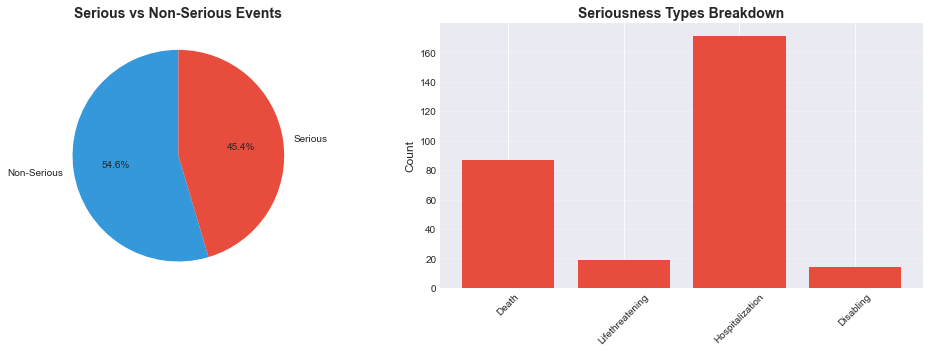

✓ Saved: seriousness_distribution.png


In [ ]:
# Seriousness Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Serious vs Non-serious
if 'serious' in df_ae.columns:
    serious_counts = df_ae['serious'].value_counts()
    axes[0].pie(serious_counts.values, labels=['Non-Serious', 'Serious'], autopct='%1.1f%%', 
                colors=['#3498db', '#e74c3c'], startangle=90)
    axes[0].set_title('Serious vs Non-Serious Events', fontsize=14, fontweight='bold')

# Seriousness types breakdown
seriousness_cols = ['seriousnessdeath', 'seriousnesslifethreatening', 
                    'seriousnesshospitalization', 'seriousnessdisabling']
seriousness_data = {}
for col in seriousness_cols:
    if col in df_ae.columns:
        count = df_ae[df_ae[col] == '1'].shape[0]
        seriousness_data[col.replace('seriousness', '').title()] = count

if seriousness_data:
    axes[1].bar(seriousness_data.keys(), seriousness_data.values(), color='#e74c3c')
    axes[1].set_title('Seriousness Types Breakdown', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Count', fontsize=12)
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'seriousness_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: seriousness_distribution.png")

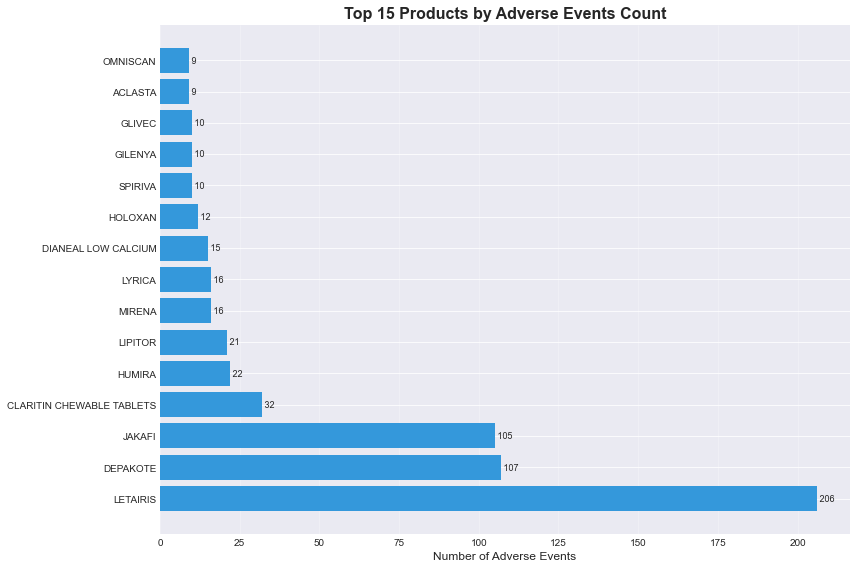

✓ Saved: top_products_adverse_events.png


In [ ]:
# Top Products with Adverse Events Graph
if 'drug_product_name' in df_ae.columns:
    top_products = df_ae['drug_product_name'].value_counts().head(15)
    fig, ax = plt.subplots(figsize=(12, 8))
    bars = ax.barh(range(len(top_products)), top_products.values, color='#3498db')
    ax.set_yticks(range(len(top_products)))
    ax.set_yticklabels(top_products.index, fontsize=10)
    ax.set_xlabel('Number of Adverse Events', fontsize=12)
    ax.set_title('Top 15 Products by Adverse Events Count', fontsize=16, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (idx, val) in enumerate(top_products.items()):
        ax.text(val, i, f' {val}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'top_products_adverse_events.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: top_products_adverse_events.png")

REGULATIONS DATA ANALYSIS

Total regulation documents: 1,880

Category distribution:
  Drugs               :   981 (52.18%)
  MedicalDevices      :   453 (24.10%)
  Biologics           :   446 (23.72%)


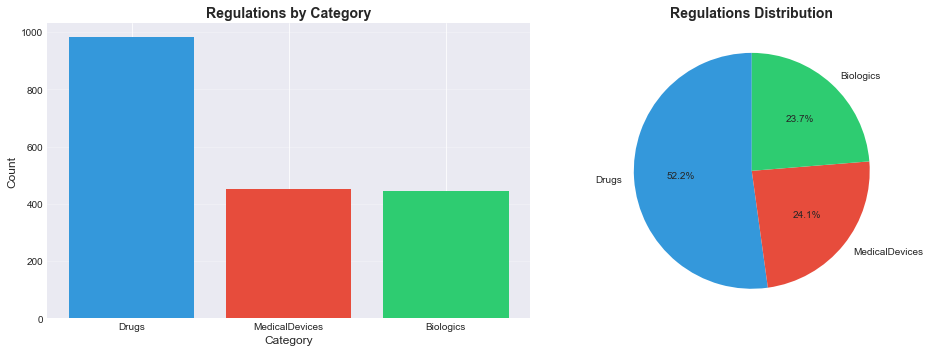

✓ Saved: regulations_distribution.png


In [ ]:
# Regulations Data Analysis Graphs
print("REGULATIONS DATA ANALYSIS")

print(f"\nTotal regulation documents: {len(df_regulations):,}")
print(f"\nCategory distribution:")
cat_counts = df_regulations['category'].value_counts()
for cat, count in cat_counts.items():
    pct = count / len(df_regulations) * 100
    print(f"  {cat:20s}: {count:5d} ({pct:5.2f}%)")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(cat_counts.index, cat_counts.values, color=['#3498db', '#e74c3c', '#2ecc71'])
axes[0].set_title('Regulations by Category', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xlabel('Category', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
axes[1].pie(cat_counts.values, labels=cat_counts.index, autopct='%1.1f%%', 
            colors=['#3498db', '#e74c3c', '#2ecc71'], startangle=90)
axes[1].set_title('Regulations Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'regulations_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: regulations_distribution.png")


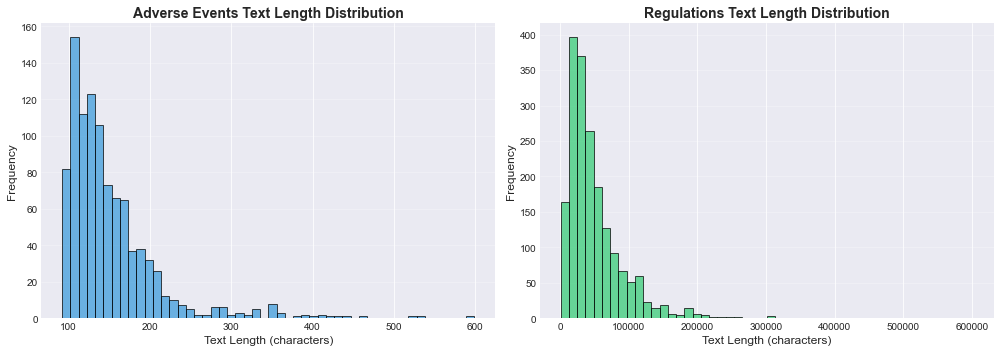

✓ Saved: text_length_analysis.png


In [ ]:
# Visualization 4: Text Length Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Adverse events text length
axes[0].hist(df_ae['ae_text_length'], bins=50, color='#3498db', edgecolor='black', alpha=0.7)
axes[0].set_title('Adverse Events Text Length Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Text Length (characters)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Regulations text length
axes[1].hist(df_regulations['char_len'], bins=50, color='#2ecc71', edgecolor='black', alpha=0.7)
axes[1].set_title('Regulations Text Length Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Text Length (characters)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'text_length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: text_length_analysis.png")


## Build Matching Model with FAISS - High-Speed Similarity Search Library.


In [ ]:
# Load embedding model
print(f"Loading embedding model: {EMBEDDING_MODEL}")
embedding_model = SentenceTransformer(EMBEDDING_MODEL)
print("✓ Embedding model loaded")

# Generate embeddings for regulations
print(f"\nGenerating embeddings for {len(df_regulations):,} regulations")
print("This may take a few minutes...")

# Use processed text if available, otherwise use original
if 'clean_text_for_embedding' in df_regulations.columns:
    regulations_texts = df_regulations['clean_text_for_embedding'].tolist()
    print("Using processed regulation text (key sections extracted)")
else:
    regulations_texts = df_regulations['clean_text'].tolist()
    print("Using full regulation text")
regulations_embeddings = []

batch_size = 32
for i in tqdm(range(0, len(regulations_texts), batch_size), desc="Embedding regulations"):
    batch = regulations_texts[i:i+batch_size]
    batch_embeddings = embedding_model.encode(batch, show_progress_bar=False)
    regulations_embeddings.extend(batch_embeddings)

regulations_embeddings = np.array(regulations_embeddings).astype('float32')
print(f"✓ Generated regulations embeddings: {regulations_embeddings.shape}")

# Build FAISS index for fast similarity search
print("\nBuilding FAISS index...")
dimension = regulations_embeddings.shape[1]

if USE_COSINE_SIMILARITY:
    # Normalize embeddings for cosine similarity (inner product)
    print("Normalizing embeddings for cosine similarity")
    faiss.normalize_L2(regulations_embeddings)
    regulations_index = faiss.IndexFlatIP(dimension)  # Inner product for cosine similarity
    print("✓ Using cosine similarity (IndexFlatIP)")
else:
    regulations_index = faiss.IndexFlatL2(dimension)  # L2 distance
    print("✓ Using L2 distance (IndexFlatL2)")

regulations_index.add(regulations_embeddings)
print(f"✓ FAISS index built with {regulations_index.ntotal:,} vectors")

# Save embeddings and index
embeddings_file = OUTPUT_DIR / "regulations_embeddings.pkl"
index_file = OUTPUT_DIR / "regulations_faiss_index.bin"

with open(embeddings_file, 'wb') as f:
    pickle.dump(regulations_embeddings, f)
faiss.write_index(regulations_index, str(index_file))

print(f"✓ Saved embeddings to {embeddings_file}")
print(f"✓ Saved FAISS index to {index_file}")

Loading embedding model: all-MiniLM-L6-v2...
✓ Embedding model loaded

Generating embeddings for 1,880 regulations...
This may take a few minutes...


Embedding regulations:   0%|          | 0/59 [00:00<?, ?it/s]

✓ Generated regulations embeddings: (1880, 384)

Building FAISS index...
✓ FAISS index built with 1,880 vectors
✓ Saved embeddings to /Users/Kay Michnicki/AllCode/FDA Data Scraping/adverse_events_regulations_matching/regulations_embeddings.pkl
✓ Saved FAISS index to /Users/Kay Michnicki/AllCode/FDA Data Scraping/adverse_events_regulations_matching/regulations_faiss_index.bin


In [ ]:
# Generate embeddings for adverse events
print(f"\nGenerating embeddings for {len(df_ae):,} adverse events...")

ae_texts = df_ae['ae_text'].tolist()
ae_embeddings = []

batch_size = 32
for i in tqdm(range(0, len(ae_texts), batch_size), desc="Embedding adverse events"):
    batch = ae_texts[i:i+batch_size]
    batch_embeddings = embedding_model.encode(batch, show_progress_bar=False)
    ae_embeddings.extend(batch_embeddings)

ae_embeddings = np.array(ae_embeddings).astype('float32')
print(f"✓ Generated adverse events embeddings: {ae_embeddings.shape}")

# Normalize for cosine similarity if using cosine similarity
if USE_COSINE_SIMILARITY:
    print("Normalizing adverse event embeddings for cosine similarity...")
    faiss.normalize_L2(ae_embeddings)

# Save adverse events embeddings
ae_embeddings_file = OUTPUT_DIR / "adverse_events_embeddings.pkl"
with open(ae_embeddings_file, 'wb') as f:
    pickle.dump(ae_embeddings, f)
print(f"✓ Saved adverse events embeddings to {ae_embeddings_file}")


Generating embeddings for 1,000 adverse events...


Embedding adverse events:   0%|          | 0/32 [00:00<?, ?it/s]

✓ Generated adverse events embeddings: (1000, 384)
✓ Saved adverse events embeddings to /Users/Kay Michnicki/AllCode/FDA Data Scraping/adverse_events_regulations_matching/adverse_events_embeddings.pkl


## Match Adverse Events to Regulations


In [ ]:
# Function to find matching regulations for an adverse event
def find_matching_regulations(ae_embedding, regulations_index, df_regulations, top_k=TOP_K_REGULATIONS):
    """
    Find top matching regulations for an adverse event embedding
    
    Args:
        ae_embedding: Embedding vector for adverse event
        regulations_index: FAISS index of regulation embeddings
        df_regulations: DataFrame with regulation data
        top_k: Number of top matches to return
    
    Returns:
        List of dictionaries with matching regulation info and similarity scores
    """
    # Search in FAISS index
    ae_embedding = ae_embedding.reshape(1, -1).astype('float32')
    
    # Normalize query embedding if using cosine similarity
    if USE_COSINE_SIMILARITY:
        faiss.normalize_L2(ae_embedding)
    
    scores, indices = regulations_index.search(ae_embedding, top_k)
    
    # Convert scores to similarity scores
    matches = []
    for i, (score, idx) in enumerate(zip(scores[0], indices[0])):
        if USE_COSINE_SIMILARITY:
            # For cosine similarity (inner product), score is already between -1 and 1
            # Convert to 0-1 range: (score + 1) / 2
            # But since we normalized, scores should be in [0, 1] range already
            similarity = max(0.0, min(1.0, float(score)))  # Clamp to [0, 1]
            distance = 1.0 - similarity  # For display purposes
        else:
            # For L2 distance, convert to similarity
            similarity = 1 / (1 + score)  # Convert distance to similarity
            distance = float(score)
        
        if similarity >= MIN_SIMILARITY_SCORE:
            regulation = df_regulations.iloc[idx].to_dict()
            matches.append({
                'rank': i + 1,
                'similarity_score': float(similarity),
                'distance': float(distance),
                'regulation_category': regulation.get('category', 'Unknown'),
                'regulation_filename': regulation.get('filename', 'Unknown'),
                'regulation_text': regulation.get('clean_text', '')[:500],  # First 500 chars
                'regulation_file_path': regulation.get('file_path', ''),
            })
    
    return matches

print("✓ Matching function defined")

✓ Matching function defined


In [ ]:
# Match all adverse events to regulations
print(f"Matching {len(df_ae):,} adverse events to regulations...")
print("This may take a few minutes...")

all_matches = []
for idx in tqdm(range(len(df_ae)), desc="Matching adverse events"):
    ae_embedding = ae_embeddings[idx]
    matches = find_matching_regulations(ae_embedding, regulations_index, df_regulations, top_k=TOP_K_REGULATIONS)
    
    # Store matches with adverse event info
    ae_info = df_ae.iloc[idx].to_dict()
    all_matches.append({
        'adverse_event_id': ae_info.get('safetyreportid', f'AE_{idx}'),
        'adverse_event_text': ae_info.get('ae_text', ''),
        'product_name': ae_info.get('drug_product_name', 'Unknown'),
        'serious': ae_info.get('serious', '0'),
        'adverse_reactions': ae_info.get('adverse_reactions', ''),
        'outcome': ae_info.get('outcome', ''),
        'matches': matches,
        'num_matches': len(matches)
    })

print(f"\n✓ Matched {len(all_matches):,} adverse events")
print(f"  Total matches found: {sum(m['num_matches'] for m in all_matches):,}")
print(f"  Average matches per event: {np.mean([m['num_matches'] for m in all_matches]):.2f}")

Matching 1,000 adverse events to regulations...
This may take a few minutes...


Matching adverse events:   0%|          | 0/1000 [00:00<?, ?it/s]


✓ Matched 1,000 adverse events
  Total matches found: 5,000
  Average matches per event: 5.00


In [ ]:
# Create a flattened results DataFrame for easier analysis
results_rows = []
for match_data in all_matches:
    ae_id = match_data['adverse_event_id']
    for match in match_data['matches']:
        results_rows.append({
            'adverse_event_id': ae_id,
            'adverse_event_text': match_data['adverse_event_text'],
            'product_name': match_data['product_name'],
            'serious': match_data['serious'],
            'adverse_reactions': match_data['adverse_reactions'],
            'outcome': match_data['outcome'],
            'regulation_category': match['regulation_category'],
            'regulation_filename': match['regulation_filename'],
            'similarity_score': match['similarity_score'],
            'match_rank': match['rank'],
            'regulation_text_preview': match['regulation_text'],
            'regulation_file_path': match['regulation_file_path']
        })

df_matches = pd.DataFrame(results_rows)
print(f"✓ Created matches DataFrame: {df_matches.shape}")
print(f"\nMatch statistics:")
print(f"  Total matches: {len(df_matches):,}")
print(f"  Unique adverse events matched: {df_matches['adverse_event_id'].nunique():,}")
print(f"  Unique regulations matched: {df_matches['regulation_filename'].nunique():,}")
print(f"\nAverage similarity scores by rank:")
print(df_matches.groupby('match_rank')['similarity_score'].mean())

df_matches.head(10)

✓ Created matches DataFrame: (5000, 12)

Match statistics:
  Total matches: 5,000
  Unique adverse events matched: 1,000
  Unique regulations matched: 488

Average similarity scores by rank:
match_rank
1    0.481826
2    0.473847
3    0.469914
4    0.467151
5    0.465187
Name: similarity_score, dtype: float64


,adverse_event_id,adverse_event_text,product_name,serious,adverse_reactions,outcome,regulation_category,regulation_filename,similarity_score,match_rank,regulation_text_preview,regulation_file_path
0,5801206-7,"Product: DURAGESIC-100 | Generic name: | Brand name: | Adverse reactions: DRUG ADMINISTRATION ERROR, OVERDOSE | Seriousness: serious, death | Outcome:",DURAGESIC-100,1,"DRUG ADMINISTRATION ERROR, OVERDOSE",,Drugs,PDF-9535-KBPDF-9535-KB-of-Postmarketing-Adverse-Experience-Reporting-for-Human-Drug-and-Licensed-Biological-Products-Clarification-of-What-to-Report_20251026_192523.txt,0.537699,1,Document Title: PDF (95.35 KB)PDF (95.35 KB) of Postmarketing Adverse Experience Reporting for Human Drug and Licensed Biological Products: Clarification of What to Report\nExtracted on: 2025-10-2...,/Users/Kay Michnicki/AllCode/FDA Data Scraping/fda_output/Drugs/text/PDF-9535-KBPDF-9535-KB-of-Postmarketing-Adverse-Experience-Reporting-for-Human-Drug-and-Licensed-Biological-Products-Clarificat...
1,5801206-7,"Product: DURAGESIC-100 | Generic name: | Brand name: | Adverse reactions: DRUG ADMINISTRATION ERROR, OVERDOSE | Seriousness: serious, death | Outcome:",DURAGESIC-100,1,"DRUG ADMINISTRATION ERROR, OVERDOSE",,Drugs,PDF-39605-KBPDF-39605-KB-of-Competitive-Generic-Therapies_20251026_190459.txt,0.530355,2,Document Title: PDF (396.05 KB)PDF (396.05 KB) of Competitive Generic Therapies\nExtracted on: 2025-10-26 19:04:59\n================================================================================...,/Users/Kay Michnicki/AllCode/FDA Data Scraping/fda_output/Drugs/text/PDF-39605-KBPDF-39605-KB-of-Competitive-Generic-Therapies_20251026_190459.txt
2,5801206-7,"Product: DURAGESIC-100 | Generic name: | Brand name: | Adverse reactions: DRUG ADMINISTRATION ERROR, OVERDOSE | Seriousness: serious, death | Outcome:",DURAGESIC-100,1,"DRUG ADMINISTRATION ERROR, OVERDOSE",,Drugs,PDF-11138-KBPDF-11138-KB-of-Product-Name-Placement-Size-and-Prominence-in-Advertising-and-Promotional-Labeling-Final_20251026_191333.txt,0.519267,3,"Document Title: PDF (111.38 KB)PDF (111.38 KB) of Product Name Placement, Size, and Prominence in Advertising and Promotional Labeling-Final\nExtracted on: 2025-10-26 19:13:33\n===================...",/Users/Kay Michnicki/AllCode/FDA Data Scraping/fda_output/Drugs/text/PDF-11138-KBPDF-11138-KB-of-Product-Name-Placement-Size-and-Prominence-in-Advertising-and-Promotional-Labeling-Final_20251026_1...
3,5801206-7,"Product: DURAGESIC-100 | Generic name: | Brand name: | Adverse reactions: DRUG ADMINISTRATION ERROR, OVERDOSE | Seriousness: serious, death | Outcome:",DURAGESIC-100,1,"DRUG ADMINISTRATION ERROR, OVERDOSE",,Drugs,PDF-21198-KBPDF-21198-KB-of-Safety-Considerations-for-Product-Design-to-Minimize-Medication-Errors-Guidance-for-Industry_20251026_191528.txt,0.517005,4,Document Title: PDF (211.98 KB)PDF (211.98 KB) of Safety Considerations for Product Design to Minimize Medication Errors Guidance for Industry\nExtracted on: 2025-10-26 19:15:29\n=================...,/Users/Kay Michnicki/AllCode/FDA Data Scraping/fda_output/Drugs/text/PDF-21198-KBPDF-21198-KB-of-Safety-Considerations-for-Product-Design-to-Minimize-Medication-Errors-Guidance-for-Industry_202510...
4,5801206-7,"Product: DURAGESIC-100 | Generic name: | Brand name: | Adverse reactions: DRUG ADMINISTRATION ERROR, OVERDOSE | Seriousness: serious, death | Outcome:",DURAGESIC-100,1,"DRUG ADMINISTRATION ERROR, OVERDOSE",,Drugs,PDF-30333-KBPDF-30333-KB-of-Brief-Summary-and-Adequate-Directions-for-Use-Disclosing-Risk-Information-in-Consumer-Directed-Print-Advertisements-and-Promotional-Labeling-for-Prescription-Drugs_2025...,0.515814,5,Document Title: PDF (303.33 KB)PDF (303.33 KB) of Brief Summary and Adequate Directions for Use: Disclosing Risk Information in Consumer-Directed Print Advertisements and Promotional Labeling for ...,/Users/Kay Michnicki/AllCode/FDA Data Scraping/fda_output/Drugs/text/PDF-30333-KBPDF-30333-KB-of-Brief-Summary-and-Adequate-Directions-for-Use-D

## Visualizations of Matches


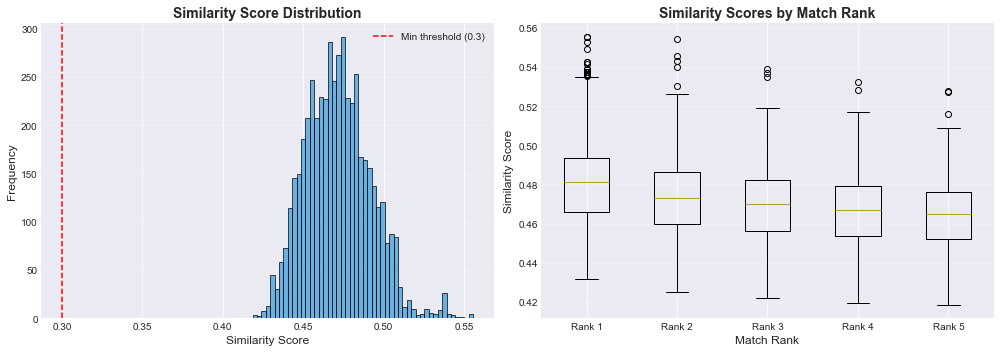

✓ Saved: similarity_scores_distribution.png


In [ ]:
# Similarity Score Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of similarity scores
axes[0].hist(df_matches['similarity_score'], bins=50, color='#3498db', edgecolor='black', alpha=0.7)
axes[0].set_title('Similarity Score Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Similarity Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].axvline(MIN_SIMILARITY_SCORE, color='r', linestyle='--', label=f'Min threshold ({MIN_SIMILARITY_SCORE})')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Box plot by match rank
rank_order = sorted(df_matches['match_rank'].unique())
box_data = [df_matches[df_matches['match_rank'] == r]['similarity_score'].values for r in rank_order]
axes[1].boxplot(box_data, labels=[f'Rank {r}' for r in rank_order])
axes[1].set_title('Similarity Scores by Match Rank', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Match Rank', fontsize=12)
axes[1].set_ylabel('Similarity Score', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'similarity_scores_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: similarity_scores_distribution.png")

The similarity scores fall within a narrow band around 0.45–0.50, showing that the model produces very uniform matches overall. The boxplots for the top five ranks also overlap heavily, with only small differences in median values. This suggests that the model is not separating strong matches from weaker ones, and that even the highest-ranked matches are only marginally better than the rest.

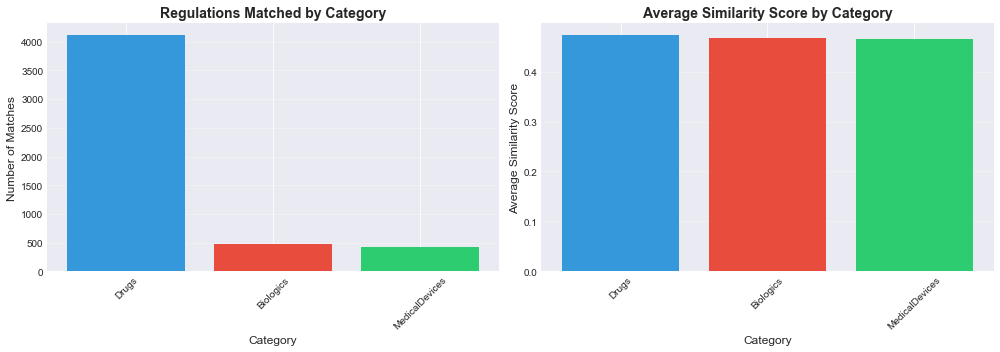

✓ Saved: matches_by_category.png


In [ ]:
# Visualization: Regulations matched by category
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count matches by regulation category
category_counts = df_matches['regulation_category'].value_counts()
axes[0].bar(category_counts.index, category_counts.values, color=['#3498db', '#e74c3c', '#2ecc71'])
axes[0].set_title('Regulations Matched by Category', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Matches', fontsize=12)
axes[0].set_xlabel('Category', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Average similarity by category
category_avg_sim = df_matches.groupby('regulation_category')['similarity_score'].mean().sort_values(ascending=False)
axes[1].bar(category_avg_sim.index, category_avg_sim.values, color=['#3498db', '#e74c3c', '#2ecc71'])
axes[1].set_title('Average Similarity Score by Category', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Average Similarity Score', fontsize=12)
axes[1].set_xlabel('Category', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'matches_by_category.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: matches_by_category.png")

The average similarity score by category is low across all three. 

## Generate Recommendations & Export Results


In [ ]:
# Create summary report for each adverse event
def generate_recommendations(match_data):
    """Generate actionable recommendations based on matches"""
    recommendations = []
    
    if match_data['num_matches'] == 0:
        return ["No relevant regulations found. Consider reviewing general FDA guidelines."]
    
    # Group matches by category
    by_category = {}
    for match in match_data['matches']:
        cat = match['regulation_category']
        if cat not in by_category:
            by_category[cat] = []
        by_category[cat].append(match)
    
    # Generate recommendations
    recommendations.append(f"Found {match_data['num_matches']} relevant regulation(s) across {len(by_category)} category/categories:")
    
    for cat, matches in by_category.items():
        recommendations.append(f"\n{cat} Regulations ({len(matches)} match/es):")
        for match in matches[:3]:  # Top 3 per category
            recommendations.append(
                f"  - {match['regulation_filename']} (Relevance: {match['similarity_score']:.2%})"
            )
    
    # Add action items
    recommendations.append("\nRecommended Actions:")
    recommendations.append("  1. Review the matched regulations to understand compliance requirements")
    recommendations.append("  2. Identify specific sections that address the reported adverse event")
    recommendations.append("  3. Update product documentation and procedures accordingly")
    recommendations.append("  4. Consider additional testing or monitoring if required")
    
    return "\n".join(recommendations)

# Add recommendations to match data
for match_data in all_matches:
    match_data['recommendations'] = generate_recommendations(match_data)

print("✓ Generated recommendations for all adverse events")


✓ Generated recommendations for all adverse events


In [ ]:
# Export results to CSV
print("Exporting results:")

# Export detailed matches
matches_export = df_matches.copy()
# Remove long text fields for CSV export
matches_export = matches_export.drop(columns=['regulation_text_preview'])
matches_csv = OUTPUT_DIR / "adverse_events_regulations_matches.csv"
matches_export.to_csv(matches_csv, index=False)
print(f"✓ Exported matches to {matches_csv}")

# Export summary by adverse event
summary_rows = []
for match_data in all_matches:
    summary_rows.append({
        'adverse_event_id': match_data['adverse_event_id'],
        'product_name': match_data['product_name'],
        'serious': match_data['serious'],
        'adverse_reactions': match_data['adverse_reactions'],
        'outcome': match_data['outcome'],
        'num_matches': match_data['num_matches'],
        'top_match_score': max([m['similarity_score'] for m in match_data['matches']]) if match_data['matches'] else 0,
        'top_match_category': match_data['matches'][0]['regulation_category'] if match_data['matches'] else 'None',
        'recommendations': match_data['recommendations']
    })

df_summary = pd.DataFrame(summary_rows)
summary_csv = OUTPUT_DIR / "adverse_events_summary_with_recommendations.csv"
df_summary.to_csv(summary_csv, index=False)
print(f"✓ Exported summary to {summary_csv}")

# Export full results as JSON
results_json = OUTPUT_DIR / "adverse_events_regulations_matches.json"
with open(results_json, 'w') as f:
    json.dump(all_matches, f, indent=2, default=str)
print(f"✓ Exported full results to {results_json}")
print(f"\n✓ All results exported to {OUTPUT_DIR}")

Exporting results...
✓ Exported matches to /Users/Kay Michnicki/AllCode/FDA Data Scraping/adverse_events_regulations_matching/adverse_events_regulations_matches.csv
✓ Exported summary to /Users/Kay Michnicki/AllCode/FDA Data Scraping/adverse_events_regulations_matching/adverse_events_summary_with_recommendations.csv
✓ Exported full results to /Users/Kay Michnicki/AllCode/FDA Data Scraping/adverse_events_regulations_matching/adverse_events_regulations_matches.json

✓ All results exported to /Users/Kay Michnicki/AllCode/FDA Data Scraping/adverse_events_regulations_matching


## Example: View Matches for Specific Adverse Event


In [ ]:
# Display matches for a specific adverse event
def display_ae_matches(ae_id_or_index):
    """Display detailed matches for an adverse event"""
    # Find the adverse event
    if isinstance(ae_id_or_index, int):
        match_data = all_matches[ae_id_or_index]
    else:
        match_data = next((m for m in all_matches if m['adverse_event_id'] == str(ae_id_or_index)), None)
        if not match_data:
            print(f"Adverse event {ae_id_or_index} not found")
            return

    print("ADVERSE EVENT DETAILS")
    print(f"\nEvent ID: {match_data['adverse_event_id']}")
    print(f"Product: {match_data['product_name']}")
    print(f"Serious: {match_data['serious']}")
    print(f"Adverse Reactions: {match_data['adverse_reactions']}")
    print(f"Outcome: {match_data['outcome']}")
    print(f"\nEvent Description:")
    print(f"  {match_data['adverse_event_text']}")
    
    print(f"MATCHED REGULATIONS ({match_data['num_matches']} found)")
    
    if not match_data['matches']:
        print("\n⚠ No regulations matched above the similarity threshold.")
    else:
        for i, match in enumerate(match_data['matches'], 1):
            print(f"\n[Match {i}]")
            print(f"  Category: {match['regulation_category']}")
            print(f"  File: {match['regulation_filename']}")
            print(f"  Similarity Score: {match['similarity_score']:.4f} ({match['similarity_score']*100:.1f}%)")
            print(f"  Regulation Preview: {match['regulation_text'][:300]}...")
    
    print("RECOMMENDATIONS")
    print(match_data['recommendations'])

# Example: Display matches for first adverse event
if len(all_matches) > 0:
    print("Example: Displaying matches for first adverse event\n")
    display_ae_matches(0)


Example: Displaying matches for first adverse event

ADVERSE EVENT DETAILS

Event ID: 5801206-7
Product: DURAGESIC-100
Serious: 1
Adverse Reactions: DRUG ADMINISTRATION ERROR, OVERDOSE
Outcome: 

Event Description:
  Product: DURAGESIC-100 | Generic name:  | Brand name:  | Adverse reactions: DRUG ADMINISTRATION ERROR, OVERDOSE | Seriousness: serious, death | Outcome: 
MATCHED REGULATIONS (5 found)

[Match 1]
  Category: Drugs
  File: PDF-9535-KBPDF-9535-KB-of-Postmarketing-Adverse-Experience-Reporting-for-Human-Drug-and-Licensed-Biological-Products-Clarification-of-What-to-Report_20251026_192523.txt
  Similarity Score: 0.5377 (53.8%)
  Regulation Preview: Document Title: PDF (95.35 KB)PDF (95.35 KB) of Postmarketing Adverse Experience Reporting for Human Drug and Licensed Biological Products: Clarification of What to Report
Extracted on: 2025-10-26 19:25:24

Guidance for...

[Match 2]
  Category: Drugs
  File: PDF-39605-KBPDF-39605-KB-of-Competitive-Generic-Therapies_20251026_190459.tx

## Summary Statistics


In [ ]:
# summary statistics
print("MATCHING SUMMARY STATISTICS")

print(f"\nTotal Adverse Events Processed: {len(all_matches):,}")
print(f"Total Matches Found: {len(df_matches):,}")
print(f"Average Matches per Event: {np.mean([m['num_matches'] for m in all_matches]):.2f}")
print(f"Events with No Matches: {sum(1 for m in all_matches if m['num_matches'] == 0):,}")

print(f"\nSimilarity Score Statistics:")
print(f"  Mean: {df_matches['similarity_score'].mean():.4f}")
print(f"  Median: {df_matches['similarity_score'].median():.4f}")
print(f"  Min: {df_matches['similarity_score'].min():.4f}")
print(f"  Max: {df_matches['similarity_score'].max():.4f}")

print(f"\nTop Matched Regulations:")
top_regs = df_matches['regulation_filename'].value_counts().head(10)
for reg, count in top_regs.items():
    print(f"  {reg}: {count} matches")

print(f"\nMatches by Regulation Category:")
for cat, count in df_matches['regulation_category'].value_counts().items():
    pct = count / len(df_matches) * 100
    print(f"  {cat}: {count:,} ({pct:.1f}%)")

print("✓ Matching complete! Results exported to output directory.")


MATCHING SUMMARY STATISTICS

Total Adverse Events Processed: 1,000
Total Matches Found: 5,000
Average Matches per Event: 5.00
Events with No Matches: 0

Similarity Score Statistics:
  Mean: 0.4716
  Median: 0.4708
  Min: 0.4185
  Max: 0.5555

Top Matched Regulations:
  PDF-39605-KBPDF-39605-KB-of-Competitive-Generic-Therapies_20251026_190459.txt: 351 matches
  PDF-11138-KBPDF-11138-KB-of-Product-Name-Placement-Size-and-Prominence-in-Advertising-and-Promotional-Labeling-Final_20251026_191333.txt: 199 matches
  of-Adverse-Reactions-Section-of-Labeling-for-Human-Prescription-Drug-and-Biological-Products-Content-and-Format_20251026_192156.txt: 198 matches
  PDF-11473-KBPDF-11473-KB-of-Nonproprietary-Naming-of-Biological-Products-Guidance-for-Industry_20251026_191426.txt: 161 matches
  PDF-18913-KBPDF-18913-KB-of-Contents-of-a-Complete-Submission-for-the-Evaluation-of-Proprietary-Names_20251026_191530.txt: 118 matches
  PDF-25627-KBPDF-25627-KB-of-Postoperative-Nausea-and-Vomiting-Developin

## Visualizations of Matching Results


Top Matched Regulations


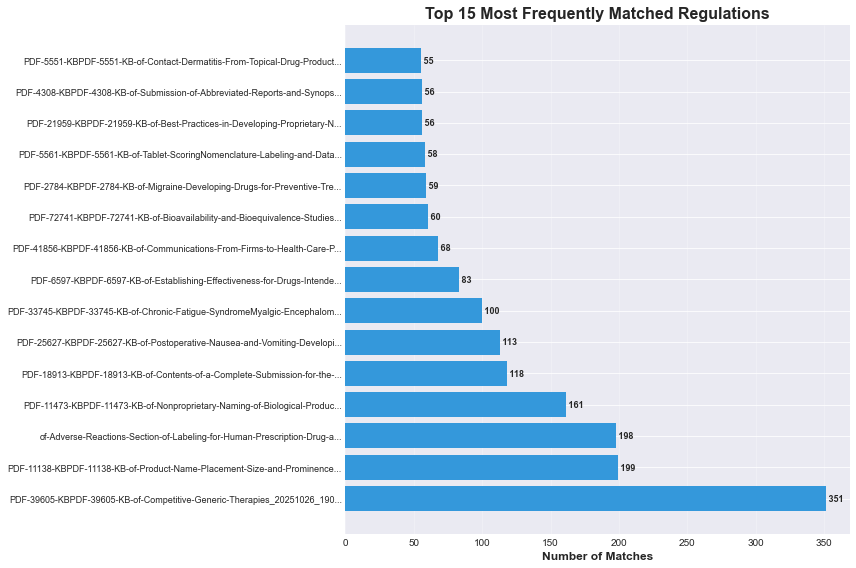

✓ Saved: top_matched_regulations.png


In [ ]:
# Top Matched Regulations Graph
print("Top Matched Regulations")

top_regs = df_matches['regulation_filename'].value_counts().head(15)

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(range(len(top_regs)), top_regs.values, color='#3498db')
ax.set_yticks(range(len(top_regs)))
# Shorten long filenames for better display
short_names = [f[:70] + '...' if len(f) > 70 else f for f in top_regs.index]
ax.set_yticklabels(short_names, fontsize=9)
ax.set_xlabel('Number of Matches', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Most Frequently Matched Regulations', fontsize=16, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, val) in enumerate(top_regs.items()):
    ax.text(val, i, f' {val}', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'top_matched_regulations.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: top_matched_regulations.png")

The matching outcome shown here is motly related to drug rather than biologics and medical devices. There is a significant larger numbers of regulations for drugs than for the other two categories.

Top Products by Average Match Quality


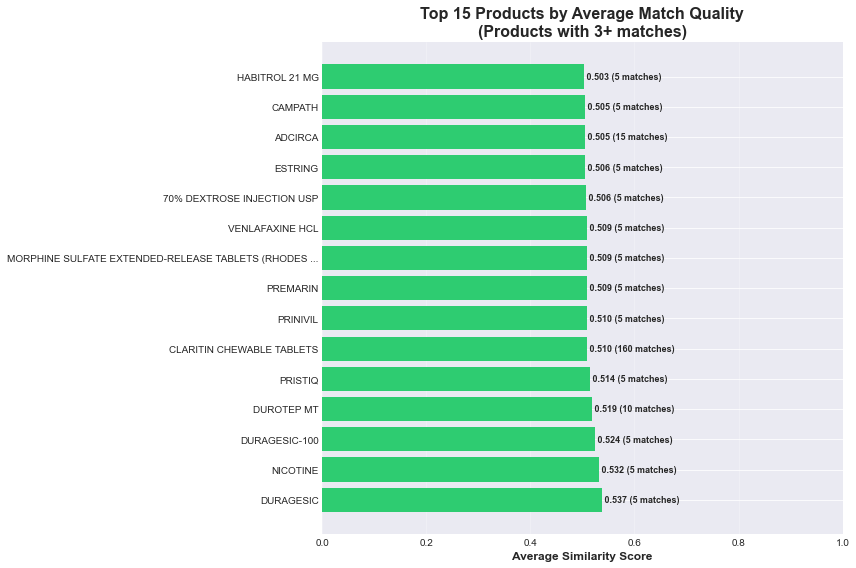

✓ Saved: top_products_by_match_quality.png


In [ ]:
# Top Products by Match Quality
print("Top Products by Average Match Quality")

# Average similarity score by product (only products with multiple matches)
product_stats = df_matches.groupby('product_name').agg({
    'similarity_score': ['mean', 'count']
}).reset_index()
product_stats.columns = ['product_name', 'avg_similarity', 'match_count']
# Filter products with at least 3 matches for better reliability
product_stats_filtered = product_stats[product_stats['match_count'] >= 3]
product_avg_sim = product_stats_filtered.nlargest(15, 'avg_similarity')

if len(product_avg_sim) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))
    bars = ax.barh(range(len(product_avg_sim)), product_avg_sim['avg_similarity'].values, color='#2ecc71')
    ax.set_yticks(range(len(product_avg_sim)))
    # Shorten product names
    short_names = [p[:50] + '...' if len(p) > 50 else p for p in product_avg_sim['product_name']]
    ax.set_yticklabels(short_names, fontsize=10)
    ax.set_xlabel('Average Similarity Score', fontsize=12, fontweight='bold')
    ax.set_title('Top 15 Products by Average Match Quality\n(Products with 3+ matches)', fontsize=16, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (idx, row) in enumerate(product_avg_sim.iterrows()):
        ax.text(row['avg_similarity'], i, f" {row['avg_similarity']:.3f} ({int(row['match_count'])} matches)", 
                va='center', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'top_products_by_match_quality.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: top_products_by_match_quality.png")
else:
    print("⚠ Not enough product data for visualization")


Score by Match Rank


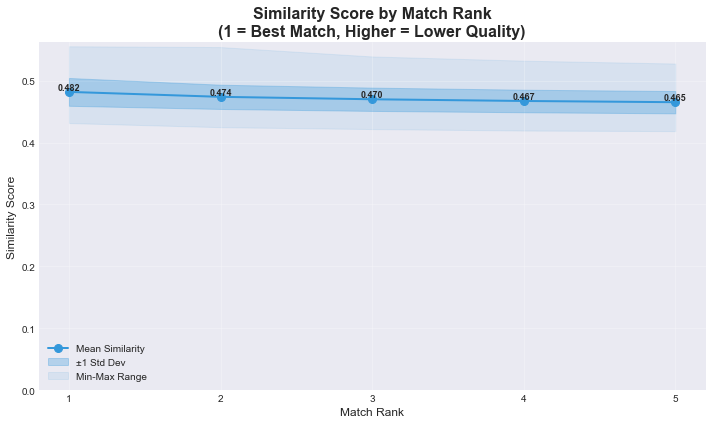

✓ Saved: similarity_by_rank.png


In [ ]:
# Score by Match Rank
print("Score by Match Rank")

rank_stats = df_matches.groupby('match_rank')['similarity_score'].agg(['mean', 'std', 'min', 'max'])

fig, ax = plt.subplots(figsize=(10, 6))

# Line plot with error bars
ax.plot(rank_stats.index, rank_stats['mean'], marker='o', linewidth=2, markersize=8, 
        color='#3498db', label='Mean Similarity', zorder=3)
ax.fill_between(rank_stats.index, 
                rank_stats['mean'] - rank_stats['std'], 
                rank_stats['mean'] + rank_stats['std'],
                alpha=0.3, color='#3498db', label='±1 Std Dev', zorder=1)

# Add min/max range
ax.fill_between(rank_stats.index,
                rank_stats['min'],
                rank_stats['max'],
                alpha=0.1, color='#3498db', label='Min-Max Range', zorder=0)

ax.set_title('Similarity Score by Match Rank\n(1 = Best Match, Higher = Lower Quality)', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Match Rank', fontsize=12)
ax.set_ylabel('Similarity Score', fontsize=12)
ax.set_xticks(rank_stats.index)
ax.grid(alpha=0.3, zorder=0)
ax.legend(loc='best')
ax.set_ylim(bottom=0)

# Add value labels on points
for rank in rank_stats.index:
    ax.text(rank, rank_stats.loc[rank, 'mean'], f"{rank_stats.loc[rank, 'mean']:.3f}",
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'similarity_by_rank.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: similarity_by_rank.png")


Matching Dashboard


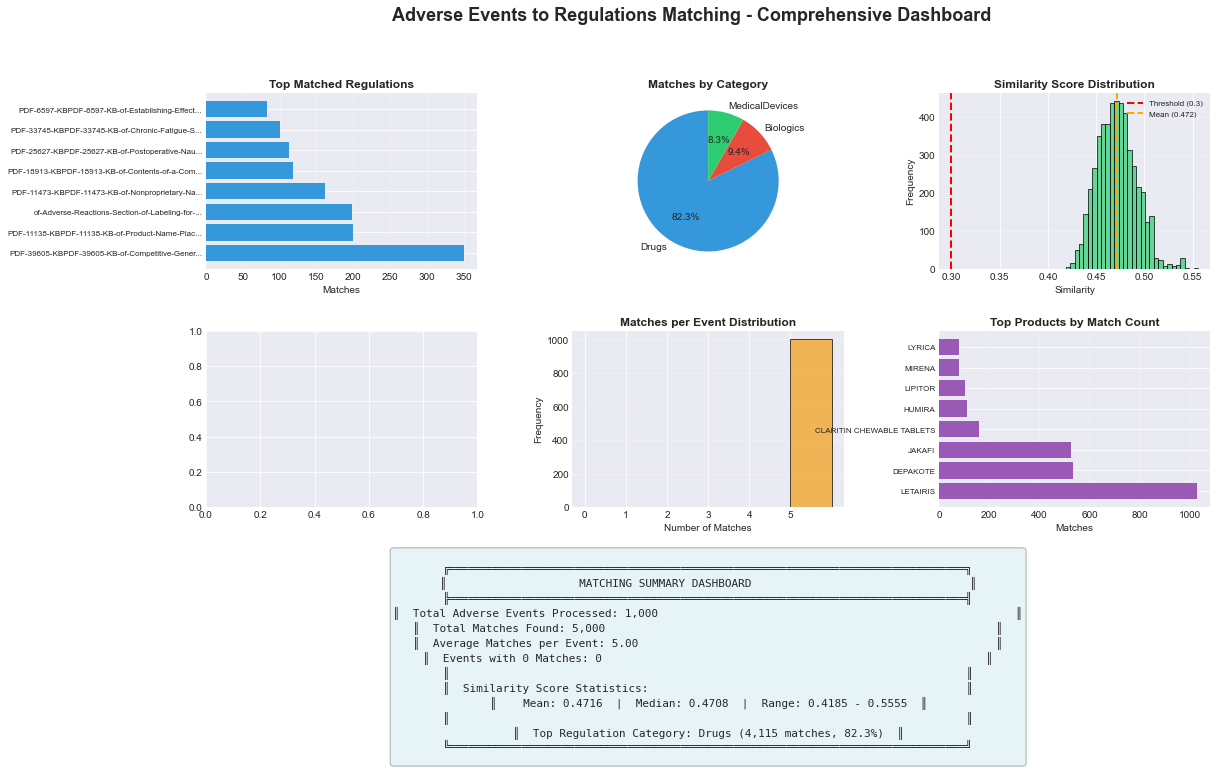

✓ Saved: matching_dashboard.png


In [ ]:
# Matching Dashboard
print("Matching Dashboard")

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.35)

# 1. Top matched regulations (top left)
ax1 = fig.add_subplot(gs[0, 0])
top_regs = df_matches['regulation_filename'].value_counts().head(8)
ax1.barh(range(len(top_regs)), top_regs.values, color='#3498db')
ax1.set_yticks(range(len(top_regs)))
ax1.set_yticklabels([f[:45]+'...' if len(f) > 45 else f for f in top_regs.index], fontsize=8)
ax1.set_title('Top Matched Regulations', fontsize=12, fontweight='bold')
ax1.set_xlabel('Matches', fontsize=10)
ax1.grid(axis='x', alpha=0.3)

# 2. Matches by category (top middle)
ax2 = fig.add_subplot(gs[0, 1])
cat_counts = df_matches['regulation_category'].value_counts()
colors_pie = ['#3498db', '#e74c3c', '#2ecc71'][:len(cat_counts)]
ax2.pie(cat_counts.values, labels=cat_counts.index, autopct='%1.1f%%', 
        startangle=90, colors=colors_pie)
ax2.set_title('Matches by Category', fontsize=12, fontweight='bold')

# 3. Similarity distribution (top right)
ax3 = fig.add_subplot(gs[0, 2])
ax3.hist(df_matches['similarity_score'], bins=30, color='#2ecc71', edgecolor='black', alpha=0.7)
ax3.axvline(MIN_SIMILARITY_SCORE, color='r', linestyle='--', linewidth=2, label=f'Threshold ({MIN_SIMILARITY_SCORE})')
ax3.axvline(df_matches['similarity_score'].mean(), color='orange', linestyle='--', linewidth=2, label=f'Mean ({df_matches["similarity_score"].mean():.3f})')
ax3.set_title('Similarity Score Distribution', fontsize=12, fontweight='bold')
ax3.set_xlabel('Similarity', fontsize=10)
ax3.set_ylabel('Frequency', fontsize=10)
ax3.legend(fontsize=8)
ax3.grid(axis='y', alpha=0.3)

# 4. Match quality by seriousness (middle left)
ax4 = fig.add_subplot(gs[1, 0])
if 'serious' in df_matches_with_serious.columns and len(df_matches_with_serious) > 0:
    serious_avg = df_matches_with_serious.groupby('serious')['similarity_score'].mean()
    if len(serious_avg) > 0:
        non_serious_val = serious_avg[serious_avg.index != '1'].mean() if len(serious_avg[serious_avg.index != '1']) > 0 else 0
        serious_val = serious_avg[serious_avg.index == '1'].values[0] if len(serious_avg[serious_avg.index == '1']) > 0 else 0
        if non_serious_val > 0 or serious_val > 0:
            ax4.bar(['Non-Serious', 'Serious'], [non_serious_val, serious_val],
                    color=['#3498db', '#e74c3c'])
            ax4.set_title('Match Quality by Seriousness', fontsize=12, fontweight='bold')
            ax4.set_ylabel('Avg Similarity', fontsize=10)
            ax4.grid(axis='y', alpha=0.3)
            ax4.text(0, non_serious_val, f'{non_serious_val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
            ax4.text(1, serious_val, f'{serious_val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 5. Matches per event (middle center)
ax5 = fig.add_subplot(gs[1, 1])
matches_per_event = pd.Series([m['num_matches'] for m in all_matches])
ax5.hist(matches_per_event, bins=range(0, min(matches_per_event.max()+2, 11)), 
         color='#f39c12', edgecolor='black', alpha=0.7)
ax5.set_title('Matches per Event Distribution', fontsize=12, fontweight='bold')
ax5.set_xlabel('Number of Matches', fontsize=10)
ax5.set_ylabel('Frequency', fontsize=10)
ax5.set_xticks(range(0, min(matches_per_event.max()+1, 10)))
ax5.grid(axis='y', alpha=0.3)

# 6. Top products by match count (middle right)
ax6 = fig.add_subplot(gs[1, 2])
top_products = df_matches['product_name'].value_counts().head(8)
if len(top_products) > 0:
    ax6.barh(range(len(top_products)), top_products.values, color='#9b59b6')
    ax6.set_yticks(range(len(top_products)))
    ax6.set_yticklabels([p[:35]+'...' if len(p) > 35 else p for p in top_products.index], fontsize=8)
    ax6.set_title('Top Products by Match Count', fontsize=12, fontweight='bold')
    ax6.set_xlabel('Matches', fontsize=10)
    ax6.grid(axis='x', alpha=0.3)

# 7. Summary stats (bottom spanning)
ax7 = fig.add_subplot(gs[2, :])
ax7.axis('off')

summary_text = f"""
----------------------MATCHING SUMMARY DASHBOARD-----------------                                 
Total Adverse Events Processed: {len(all_matches):,}                                                      
Total Matches Found: {len(df_matches):,}                                                           
Average Matches per Event: {matches_per_event.mean():.2f}                                                      
Events with 0 Matches: {(matches_per_event == 0).sum()}                                                                                                                                       
Similarity Score Statistics:                                                
Mean: {df_matches['similarity_score'].mean():.4f}  |  Median: {df_matches['similarity_score'].median():.4f}  |  Range: {df_matches['similarity_score'].min():.4f} - {df_matches['similarity_score'].max():.4f}  
                                                                             
 Top Regulation Category: {df_matches['regulation_category'].value_counts().index[0]} ({df_matches['regulation_category'].value_counts().iloc[0]:,} matches, {df_matches['regulation_category'].value_counts().iloc[0]/len(df_matches)*100:.1f}%) 
"""

ax7.text(0.5, 0.5, summary_text, ha='center', va='center', fontsize=11, 
         family='monospace', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.suptitle('Adverse Events to Regulations Matching - Comprehensive Dashboard', 
             fontsize=18, fontweight='bold', y=0.98)
plt.savefig(OUTPUT_DIR / 'matching_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: matching_dashboard.png")

Quality by Outcome


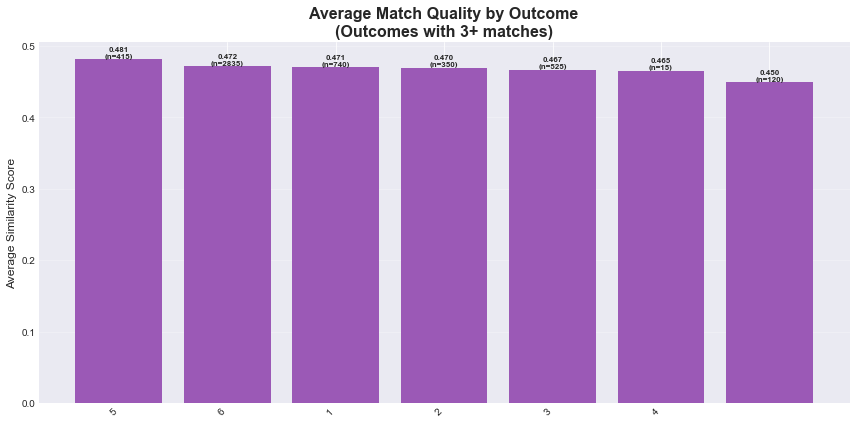

✓ Saved: match_quality_by_outcome.png


In [ ]:
# Quality by Outcome (if available)
print("Quality by Outcome")

if 'outcome' in df_matches.columns and df_matches['outcome'].notna().sum() > 0:
    outcome_avg = df_matches.groupby('outcome')['similarity_score'].agg(['mean', 'count'])
    outcome_avg = outcome_avg[outcome_avg['count'] >= 3].sort_values('mean', ascending=False).head(10)
    
    if len(outcome_avg) > 0:
        fig, ax = plt.subplots(figsize=(12, 6))
        bars = ax.bar(range(len(outcome_avg)), outcome_avg['mean'].values, color='#9b59b6')
        ax.set_xticks(range(len(outcome_avg)))
        ax.set_xticklabels(outcome_avg.index, rotation=45, ha='right', fontsize=10)
        ax.set_title('Average Match Quality by Outcome\n(Outcomes with 3+ matches)', fontsize=16, fontweight='bold')
        ax.set_ylabel('Average Similarity Score', fontsize=12)
        ax.grid(axis='y', alpha=0.3)
        
        # Add value labels
        for i, (idx, row) in enumerate(outcome_avg.iterrows()):
            ax.text(i, row['mean'], f"{row['mean']:.3f}\n(n={int(row['count'])})", 
                    ha='center', va='bottom', fontsize=8, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / 'match_quality_by_outcome.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("✓ Saved: match_quality_by_outcome.png")
    else:
        print("⚠ Not enough outcome data for visualization")
else:
    print("⚠ Outcome data not available or insufficient")


The average match quality score is low, indicating that the current method is not adequate for identifying all of the applicable FDA regulations for an issuing letter.


VISUALIZATION 8: Heatmap - Products vs Regulation Categories


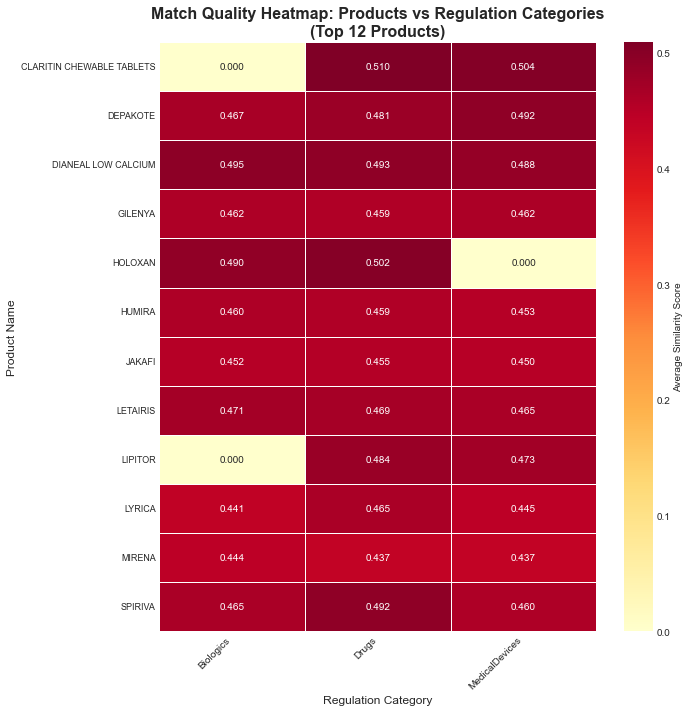

✓ Saved: product_category_heatmap.png


In [ ]:
# Heatmap - Products vs Regulation Categories
print("Heatmap - Products vs Regulation Categories")

# Create heatmap data (top products vs categories)
top_products = df_matches['product_name'].value_counts().head(12).index
heatmap_data = df_matches[df_matches['product_name'].isin(top_products)].pivot_table(
    values='similarity_score',
    index='product_name',
    columns='regulation_category',
    aggfunc='mean'
).fillna(0)

if len(heatmap_data) > 0 and len(heatmap_data.columns) > 0:
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax, 
                cbar_kws={'label': 'Average Similarity Score'}, linewidths=0.5)
    ax.set_title('Match Quality Heatmap: Products vs Regulation Categories\n(Top 12 Products)', 
                 fontsize=16, fontweight='bold')
    ax.set_xlabel('Regulation Category', fontsize=12)
    ax.set_ylabel('Product Name', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Shorten product names on y-axis
    y_labels = [label.get_text()[:40] + '...' if len(label.get_text()) > 40 else label.get_text() 
                for label in ax.get_yticklabels()]
    ax.set_yticklabels(y_labels, fontsize=9)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'product_category_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: product_category_heatmap.png")
else:
    print("⚠ Not enough data for heatmap visualization")


The heatmap shows the average similarity scores between the top 12 products and the three main FDA regulation categories—Biologics, Drugs, and Medical Devices. The color scale ranges from light yellow (low similarity) to dark red (higher similarity). Across the chart, most cells appear in deep red shades, but the actual numeric values are relatively low, clustering around 0.44–0.51, indicating moderate but not strong matches.

## Conclusion

Overall, the model produced moderately accurate matches between FDA-issued letters and the regulations that may apply to them. While not perfect, the system provides users with a helpful starting point by highlighting potentially relevant regulatory requirements that they should review and follow to reduce the risk of future rejection.